# Прогнозирование метрик

## Задача 1

Команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-10-12 по 2023-10-18. 

Задача состоит в оценке эффективности мероприятия, а также определении пяти ключевых метрик, которые могли бы измениться во время флэшмоба. Далее, используя CausalImpact, можно проверить фактическое изменение этих метрик во время флэшмоба и оценить, были ли какие-то долгосрочные эффекты.
Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите хотя бы 5 метрик.
Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.
Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы.

### Предполагаемые метрики: 

* **Среднее количество постов на человека** - есть люди, которые совсем не делают постов, но поскольку проходит флешмоб, и они захотят получить приз, они будут делать посты, приуроченные к флешмобу, из-за чего вырастет метрика
* **Общее количество просмотров за день** - можно предположить, что поскольку вырастет количество публикуемых постов, вырастет и количество просмотров по случаю флэшмоба
* **Общее количество лайков за день** - поскольку вырастет количество постов, можно предположить, что вырастут и лайки, так как эти метрики довольно близки по своей сути. Кроме того, вероятно, увеличится активность людей по случаю мероприятия, и они будут активнее лайкать на время флэшмоба
* **CTR likes/views** - больше пользовательской активности на время флэшмоба должна отразиться и на этой метрике
* **DAU** - больше пользователей будут заходить в приложение ежедневно, чтобы следить за флешмобом, просматривать, лайкать посты и т.д.

### Поскольку мы хотим измерить как изменились нужные нам метрики в неделю мероприятия (12 октября - 18 октября), мы будем сравнить их с метриками недели до флэшмоба (5 октября - 11 октября), что мы и будем далее делать для каждой из выбранных метрик.

In [1]:
import orbit
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #для визуализации MCMC

import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact

2023-11-09 11:32:13.609391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 11:32:16.552856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231020',
'user':'student',
'password':'dpo_python_2020'
}

Напишем запросы к базе данных по каждой из нужной нам метрик:

In [85]:
posts_query = '''
with daily_data as (
SELECT DATE(time) as day, user_id, count(post_id) posts
FROM 
    simulator_20231020.feed_actions
group by day, user_id
)
select day, avg(posts) AS avg_posts
FROM daily_data
GROUP BY day
ORDER BY day
'''

views_query = '''
with daily_data as (
SELECT DATE(time) as day, user_id, countIf(action = 'view') v
FROM 
    simulator_20231020.feed_actions
group by day, user_id
)
select day, sum(v) AS views
FROM daily_data
GROUP BY day
ORDER BY day
'''

likes_query = '''
with daily_data as (
SELECT DATE(time) as day, user_id, countIf(action = 'like') l
FROM 
    simulator_20231020.feed_actions
group by day, user_id
)
select day, sum(l) AS likes
FROM daily_data
GROUP BY day
ORDER BY day
'''

ctr_query = '''
SELECT 
    toStartOfDay(time) day,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM 
    simulator_20231020.feed_actions
GROUP BY day
ORDER BY 
    day
'''

dau_query = '''
with daily_data as (
SELECT DATE(time) as day, user_id
FROM 
    simulator_20231020.feed_actions
)
select day, COUNT(DISTINCT user_id) AS DAU
FROM daily_data
GROUP BY day
ORDER BY day
'''
## WHERE day >= toDateTime('2023-10-12')
## AND day <= toDateTime('2023-10-18')

In [67]:
posts = ph.read_clickhouse(posts_query, connection = connection)
views = ph.read_clickhouse(views_query, connection = connection)
likes = ph.read_clickhouse(likes_query, connection = connection)
ctr = ph.read_clickhouse(ctr_query, connection=connection)
dau = ph.read_clickhouse(dau_query, connection = connection)

## **Среднее количество постов на человека**

In [6]:
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

<Axes: xlabel='day', ylabel='avg_posts'>

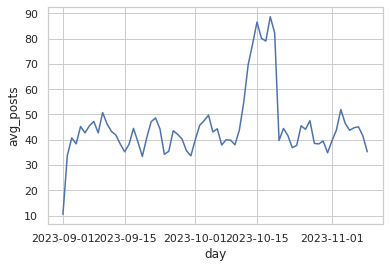

In [35]:
sns.lineplot(x = 'day', y = 'avg_posts', data = posts)

На графике можно заметить, что произошел рост в среднем количестве постов за день в нужный нам период. 

Проверим воздействие флешмоба на метрику:

In [40]:
posts_impact = CausalImpact(data=posts.set_index('day'),
                            pre_period=[pd.Timestamp('2023-10-05'),
                                 pd.Timestamp('2023-10-11')],
                            post_period=[pd.Timestamp('2023-10-12'),
                                 pd.Timestamp('2023-10-18')]) 

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-11-09 12:53:23.916320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-11-09 12:53:23.916951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-11-09 12:53:23.937124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-11-09 12:53:23.937386: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-11-09 12:53:25.595719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 12:53:25.643883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 12:53:25.710355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-11-09 12:53:44.906659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-11-09 12:53:45.038141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

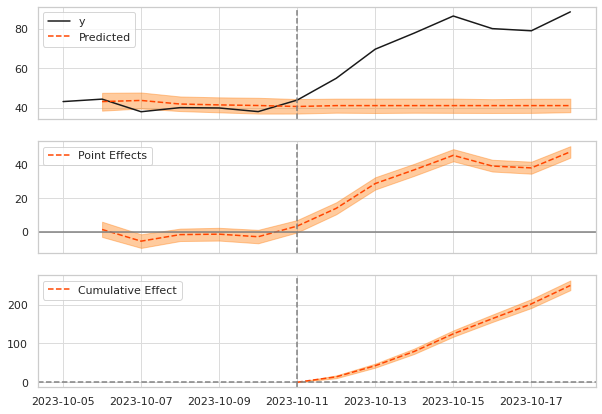

In [41]:
posts_impact.plot()

Из графика можно сделать вывод, что наблюдается прирост средних постов по каждому из дней (приблизительный рост за день от 20 до 40 постов), а общий эффект от мероприятия на метрику очень положительный, поскольку общее среднее количество постов за период флэшмоба показал прирост больше чем на 200 от того, если бы мы не проводили это мероприятие.

In [42]:
print(posts_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    76.74              537.15
Prediction (s.d.)         41.04 (0.91)       287.31 (6.38)
95% CI                    [39.28, 42.85]     [274.96, 299.98]

Absolute effect (s.d.)    35.69 (0.91)       249.84 (6.38)
95% CI                    [33.88, 37.46]     [237.17, 262.19]

Relative effect (s.d.)    86.96% (2.22%)     86.96% (2.22%)
95% CI                    [82.55%, 91.26%]   [82.55%, 91.26%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Следует заметить, что среднее количество постов выросло аж на 86%. Как мы и предполагали, люди стали публиковать посты, чтобы поучаствовать в флэшмобе, эффект положительный. Заодно посмотрим, как интерпретирует результат наша программа:

In [43]:
print(posts_impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 76.74. By contrast, in the absence of an
intervention, we would have expected an average response of 41.04.
The 95% interval of this counterfactual prediction is [39.28, 42.85].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 35.69 with a 95% interval of
[33.88, 37.46]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 537.15.
By contrast, had the intervention not taken place, we would have expected
a sum of 287.31. The 95% interval of this prediction is [274.96, 299.98].


The above results are given in terms of absolute numbers. In relative
terms, the response variab

## **Общее количество просмотров за день**

<Axes: xlabel='_day', ylabel='views'>

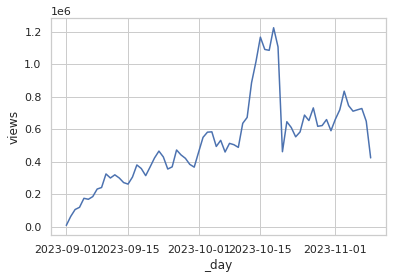

In [45]:
sns.lineplot(x = '_day', y = 'views', data = views)

Можно заметить, что количество просмотров ощутимо выросло в период флешмоба, оценим воздействие:

In [68]:
views_impact = CausalImpact(data=views.set_index('day'),
                            pre_period=[pd.Timestamp('2023-10-05'),
                                 pd.Timestamp('2023-10-11')],
                            post_period=[pd.Timestamp('2023-10-12'),
                                 pd.Timestamp('2023-10-18')]) 

2023-11-09 13:30:44.837312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:30:44.881251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:30:45.836027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:

2023-11-09 13:31:06.021614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-11-09 13:31:06.170179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

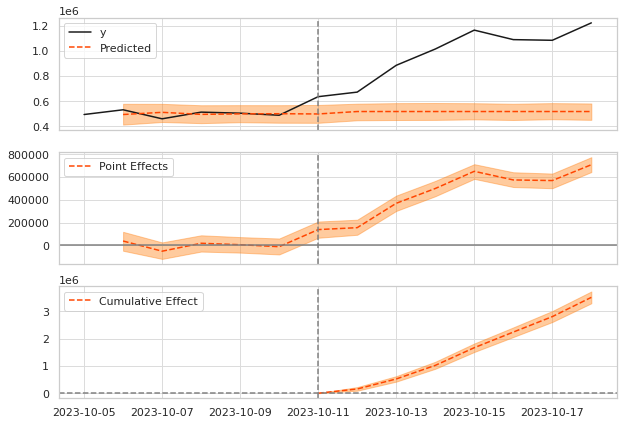

In [69]:
views_impact.plot()

In [70]:
print(views_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         517335.25 (17275.02)3621346.75 (120925.23)
95% CI                    [484241.75, 551958.61][3389692.19, 3863710.48]

Absolute effect (s.d.)    502612.06 (17275.02)3518284.25 (120925.23)
95% CI                    [467988.7, 535705.56][3275920.52, 3749938.81]

Relative effect (s.d.)    97.15% (3.34%)     97.15% (3.34%)
95% CI                    [90.46%, 103.55%]  [90.46%, 103.55%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Мы можем наблюдать большой эффект мероприятия на просмотры, поскольку наблюдается рост аж на 97% в сравнении с прошлой неделей до мероприятия, а настоящий прирост показал значение в два раза больше от прогнозируемого.

In [71]:
print(views_impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1019947.31. By contrast, in the absence of an
intervention, we would have expected an average response of 517335.25.
The 95% interval of this counterfactual prediction is [484241.75, 551958.61].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 502612.06 with a 95% interval of
[467988.7, 535705.56]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 7139631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 3621346.75. The 95% interval of this prediction is [3389692.19, 3863710.48].


The above results are given in terms of absolute numb

## **Общее количество лайков за день**

<Axes: xlabel='_day', ylabel='likes'>

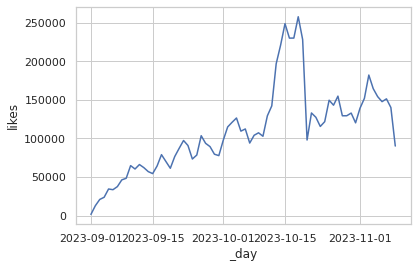

In [46]:
sns.lineplot(x = '_day', y = 'likes', data = likes)

Как в случае и с просмотрами, можно заметить, что количество лайков ощутимо выросло в период флешмоба, оценим воздействие:

In [72]:
likes_impact = CausalImpact(data=likes.set_index('day'),
                            pre_period=[pd.Timestamp('2023-10-05'),
                                 pd.Timestamp('2023-10-11')],
                            post_period=[pd.Timestamp('2023-10-12'),
                                 pd.Timestamp('2023-10-18')]) 

2023-11-09 13:32:25.763821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:32:25.803737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:32:27.684919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:

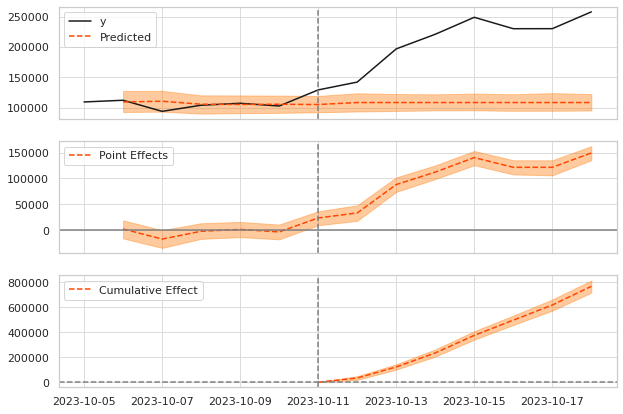

In [73]:
likes_impact.plot()

In [74]:
print(likes_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         108555.7 (3511.65) 759889.88 (24581.52)
95% CI                    [101636.43, 115401.84][711455.04, 807812.84]

Absolute effect (s.d.)    109534.45 (3511.65)766741.12 (24581.52)
95% CI                    [102688.3, 116453.71][718818.16, 815175.96]

Relative effect (s.d.)    100.9% (3.23%)     100.9% (3.23%)
95% CI                    [94.6%, 107.28%]   [94.6%, 107.28%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


С лайками аналогичная ситуация, как и с просмотрами, заметен рост аж на 100 процентов.

In [75]:
print(likes_impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 218090.14. By contrast, in the absence of an
intervention, we would have expected an average response of 108555.7.
The 95% interval of this counterfactual prediction is [101636.43, 115401.84].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 109534.45 with a 95% interval of
[102688.3, 116453.71]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1526631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 759889.88. The 95% interval of this prediction is [711455.04, 807812.84].


The above results are given in terms of absolute numbers. 

## **CTR likes/views**

<Axes: xlabel='_day', ylabel='CTR'>

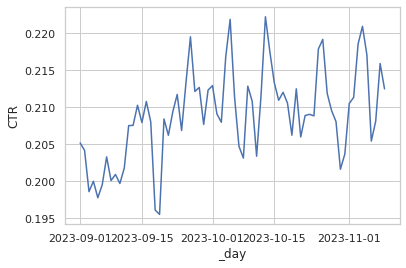

In [50]:
sns.lineplot(x = '_day', y = 'CTR', data = ctr)

In [76]:
ctr_impact = CausalImpact(data=ctr.set_index('day'),
                            pre_period=[pd.Timestamp('2023-10-05'),
                                 pd.Timestamp('2023-10-11')],
                            post_period=[pd.Timestamp('2023-10-12'),
                                 pd.Timestamp('2023-10-18')]) 

2023-11-09 13:41:33.866879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:41:33.914867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:41:34.813343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:

2023-11-09 13:41:54.055519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-11-09 13:41:54.212914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

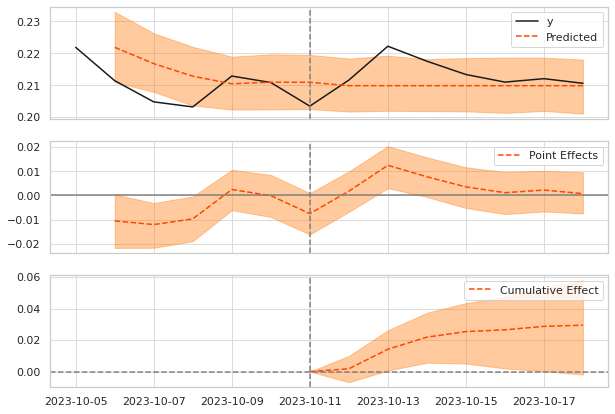

In [77]:
ctr_impact.plot()

In [78]:
print(ctr_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.47 (0.02)
95% CI                    [0.21, 0.21]       [1.44, 1.5]

Absolute effect (s.d.)    0.0 (0.0)          0.03 (0.02)
95% CI                    [-0.0, 0.01]       [-0.0, 0.06]

Relative effect (s.d.)    2.0% (1.04%)       2.0% (1.04%)
95% CI                    [-0.15%, 3.92%]    [-0.15%, 3.92%]

Posterior tail-area probability p: 0.03
Posterior prob. of a causal effect: 96.5%

For more details run the command: print(impact.summary('report'))


### В случае с ctr, можно заметить, что небольшой рост присутствует, однако, важно подчеркнуть, что доверительный интервал эффекта содержит 0, поэтому можно утверждать, что наблюдаемое нами изменение в ctr не является статистически значимым, и полученное изменение может быть случайностью.

In [79]:
print(ctr_impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. In the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.21, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[-0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
Had the intervention not taken place, we would have expected
a sum of 1.47. The 95% interval of this prediction is [1.44, 1.5].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +2.0%. The 95%
inte

## **DAU**

<Axes: xlabel='day', ylabel='DAU'>

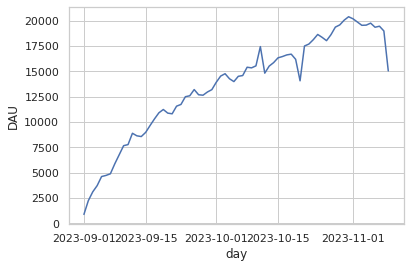

In [51]:
sns.lineplot(x="day", y="DAU", data = dau)

По этому графику сложно оценить существенен ли рост, поэтому перейдем сразу к измерению воздействия на метрику:

In [81]:
dau_impact = CausalImpact(data=dau.set_index('day'),
                            pre_period=[pd.Timestamp('2023-10-05'),
                                 pd.Timestamp('2023-10-11')],
                            post_period=[pd.Timestamp('2023-10-12'),
                                 pd.Timestamp('2023-10-18')]) 

2023-11-09 13:43:41.518493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:43:41.558779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:43:42.482638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-09 13:

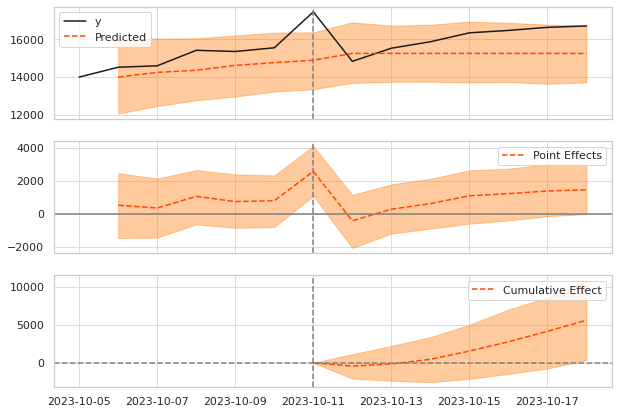

In [82]:
dau_impact.plot()

In [83]:
print(dau_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         15250.84 (400.61)  106755.9 (2804.24)
95% CI                    [14459.87, 16030.22][101219.11, 112211.55]

Absolute effect (s.d.)    801.87 (400.61)    5613.1 (2804.24)
95% CI                    [22.49, 1592.84]   [157.45, 11149.89]

Relative effect (s.d.)    5.26% (2.63%)      5.26% (2.63%)
95% CI                    [0.15%, 10.44%]    [0.15%, 10.44%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 97.6%

For more details run the command: print(impact.summary('report'))


Несмотря на то, что эффект не очень большой, прирост все же заметен, что говорит о том, что метрика DAU немного выросла.

In [84]:
print(dau_impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. By contrast, in the absence of an
intervention, we would have expected an average response of 15250.84.
The 95% interval of this counterfactual prediction is [14459.87, 16030.22].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 801.87 with a 95% interval of
[22.49, 1592.84]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 106755.9. The 95% interval of this prediction is [101219.11, 112211.55].


The above results are given in terms of absolute numbers. In relative
t

## Вывод

Исходя из полученных результатов, можно отметить, что флэшмоб увеличил вовлеченность людей в приложение, НО только лишь временно. Из плюсов можно отметить большой **рост количества просмотров и лайков** (обе метрики увеличились в два раза), а также **среднее количество постов на пользователя** (рост на 86%), что говорит о повышенном интересе людей к приложению **в период мероприятия**. С другой стороны, изменения практически не сказались на **DAU** и **CTR**, а построенные графики, которые затрагивают временной промежуток уже после события наводят на вывод, что эффект оказался краткосрочным, а метрики вернулись до показателей перед началом флэшмоба (cреднее количество постов на человека), либо же просели до стабильного роста (dau, likes, views), аналогичного периоду времени до начала мероприятия.